In [1]:
from utils import alsoknownas, birthdate, deathday, nameofperson
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
from utils import alsoknownas, birthdate, deathday, nameofperson
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
df = pd.read_csv('trainingDataset.csv',encoding='utf8')

In [3]:
df

,date,title,category,link,abstract,paragraphs
0,21.04.2020,Barack Obama,NaN,https://en.wikipedia.org/wiki/Barack_Obama,Barack Hussein Obama II ( (listen); born Augus...,['Barack Hussein Obama II ( (listen); born Aug...
1,21.04.2020,Joe Biden,NaN,https://en.wikipedia.org/wiki/Joe_Biden,Joseph Robinette Biden Jr. (; born November 20...,['Joseph Robinette Biden Jr. (; born November ...
2,21.04.2020,George W. Bush,NaN,https://en.wikipedia.org/wiki/George_W._Bush,"George Walker Bush (born July 6, 1946) is an A...","['George Walker Bush (born July 6, 1946) is an..."
3,21.04.2020,Donald Trump,NaN,https://en.wikipedia.org/wiki/Donald_Trump,"Donald John Trump (born June 14, 1946) is the ...","['Donald John Trump (born June 14, 1946) is th..."
4,21.04.2020,George Washington,NaN,https://en.wikipedia.org/wiki/George_Washington,"George Washington (February 22, 1732 – Decembe...","['George Washington (February 22, 1732 – Decem..."
...,...,...,...,...,...,...
1600,21.04.2020,Pablo Squella,NaN,https://en.wikipedia.org/wiki/Pablo_Squella,"Pablo Squella Serrano (born August 14, 1963) i...","['Pablo Squella Serrano (born August 14, 1963)..."
1601,21.04.2020,Ulises de la Cruz,NaN,https://en.wikipedia.org/wiki/Ulises_de_la_Cruz,Ulises Hernán de la Cruz Bernardo (born 8 Febr...,"[""Ulises Hernán de la Cruz Bernardo (born 8 Fe..."
1602,21.04.2020,Cecilia Tait,NaN,https://en.wikipedia.org/wiki/Cecilia_Tait,"Cecilia Roxana Tait Villacorta (born May 2, 19...","['Cecilia Roxana Tait Villacorta (born May 2, ..."
1603,21.04.2020,Cenaida Uribe,NaN,https://en.wikipedia.org/wiki/Cenaida_Uribe,Cenaida Cebastiana Uribe Medina (born December...,['Cenaida Cebastiana Uribe Medina (born Decemb...


In [4]:
# Convert to list
data = df.abstract.values.tolist()

In [5]:
#Converting the sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  #Using the gensim.simple_preprocess,deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['barack', 'hussein', 'obama', 'ii', 'listen', 'born', 'august', 'is', 'an', 'american', 'politician', 'and', 'attorney', 'who', 'served', 'as', 'the', 'th', 'president', 'of', 'the', 'united', 'states', 'from', 'to']]


In [6]:
#Lemmatization function
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['listen bear american politician attorney serve th president', 'bear american politician serve vice president represent delaware']


In [7]:
#Using the count vectorizer to convert words to vectors
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=2,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}' # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [8]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.7767335711000616 %


In [9]:
#Building the LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics = 2-
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [10]:
# Log Likelyhood
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -51560.20638433447
Perplexity:  268.4916649107709
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [11]:
# Defining the Search parameters for GridSearch
search_params = {'n_components': [120,150,180], 'learning_decay': [.5, .7, .9]}

# Initialize the model
lda = LatentDirichletAllocation()

# Initialize Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Perform grid search on the model
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [12]:
# Best LDA Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 120}
Best Log Likelihood Score:  -30436.641498698213
Model Perplexity:  410.12441611234766


[-30461.0, -34262.0, -37949.0]
[120, 150, 180]


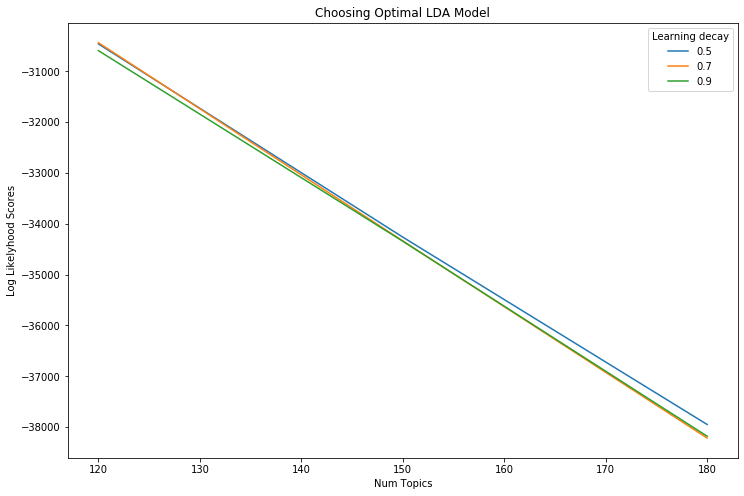

In [13]:
n_topics = [120, 150, 180]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]


print(log_likelyhoods_5)
print(n_topics)
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [14]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get the dominant topics for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling show dominant topics in green
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

#And bold
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [15]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,107,87
1,101,77
2,22,74
3,89,68
4,63,60
...,...,...
113,90,3
114,94,2
115,87,2
116,4,2


In [16]:
#Visualization
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster      Freq
topic                                                 
107    -0.484953  49.847050       1        1  3.664832
89    -21.951244 -23.755970       2        1  3.616790
22      3.075633  25.282679       3        1  2.650863
63    -24.429813 -15.443058       4        1  2.535227
101     5.427192   4.318227       5        1  2.228422
...          ...        ...     ...      ...       ...
69      3.357188  -0.927517     116        1  0.314988
94     10.323391 -26.020077     117        1  0.307716
65     17.351486 -40.836258     118        1  0.280031
100    14.026360 -32.020527     119        1  0.117697
38     13.435314 -35.466179     120        1  0.117697

[120 rows x 5 columns], topic_info=           Term        Freq       Total  Category  logprob  loglift
387      member  181.000000  181.000000   Default  30.0000  30.0000
329        know  170.000000  170.000000   Default  29.0000  29.0000
74      british  173.000000  173.000000   Default  28.0000  28.0000
491  politician  791.000000  791.000000   Default  27.0000  27.0000
41   australian  116.000000  116.000000   Default  26.0000  26.0000
..          ...         ...         ...       ...      ...      ...
266    governor    0.015112   14.574578  Topic120  -6.5765  -0.1267
265  government    0.015112   17.913171  Topic120  -6.5765  -0.3330
264      govern    0.015112    3.866773  Topic120  -6.5765   1.2001
263        good    0.015112    3.829476  Topic120  -6.5765   1.2098
262        golf    0.015112    5.012886  Topic120  -6.5765   0.9405

[5261 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0        39  0.205769   academic
0        77  0.617308   academic
1        12  0.346101    achieve
1        58  0.346101    achieve
2        48  0.100347        act
...     ...       ...        ...
715      99  0.055710       year
716      77  0.333931  yorkshire
716     103  0.333931  yorkshire
717      36  0.345897      young
717      88  0.345897      young

[2012 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[108, 90, 23, 64, 102, 32, 22, 62, 73, 110, 76, 93, 37, 30, 34, 33, 25, 8, 80, 82, 4, 117, 11, 71, 53, 41, 68, 74, 2, 107, 15, 87, 83, 106, 118, 17, 84, 67, 59, 79, 86, 44, 96, 52, 72, 92, 27, 47, 9, 26, 35, 85, 104, 89, 115, 56, 12, 113, 57, 29, 36, 18, 69, 97, 75, 109, 48, 99, 120, 105, 16, 3, 114, 112, 24, 20, 43, 42, 78, 81, 61, 45, 7, 111, 1, 103, 54, 94, 77, 38, 116, 51, 19, 63, 6, 46, 28, 58, 65, 13, 60, 10, 55, 5, 100, 49, 14, 91, 31, 88, 50, 119, 40, 21, 98, 70, 95, 66, 101, 39])

In [17]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords

,academic,achieve,act,active,activist,actor,actress,adair,addition,adelaide,...,woman,work,world,wrestler,wrestling,write,writer,year,yorkshire,young
Topic0,0.008333,0.008333,0.008333,0.008333,1.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
Topic1,0.008333,0.008333,0.008333,0.008333,0.008333,4.415713,2.733043,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
Topic2,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
Topic3,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
Topic4,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Topic115,0.008333,0.008333,0.008333,0.008333,0.008333,2.186027,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
Topic116,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,2.085476,9.758501,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
Topic117,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
Topic118,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [18]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe for 120 topics
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,taoiseach,american,guitar,socialist,establish,parliamentary,secretary,know,bear,songwriter,singer,musician,later,lead,rise
Topic 1,bear,film,television,politician,appear,model,dancer,host,actor,danish,actress,indian,member,tamil,party
Topic 2,polish,politician,bear,member,scientist,political,columnist,picture,pioneer,pitcher,planner,plantation,academic,playback,physicist
Topic 3,sport,politician,field,norwegian,track,bear,athlete,official,metre,canadian,businessperson,fencer,event,specialise,involvement
Topic 4,refer,initial,politician,fighter,baronet,horse,sit,racer,nickname,usually,tenth,bear,british,police,polish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Topic 115,politician,dutch,bear,member,theater,head,actor,freedom,convention,canadian,lankan,fighter,billionaire,party,statesman
Topic 116,bear,medal,win,summer,wrestler,olympic,gold,bronze,iranian,freestyle,hurdle,sprinter,politician,silver,world
Topic 117,russian,bear,politician,soviet,judoka,pair,skater,theater,retire,physicist,picture,pioneer,pitcher,planner,plantation
Topic 118,sabha,member,bear,lok,know,present,district,village,vote,day,elect,century,filipino,idol,professionally


In [19]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

In [20]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.01  0.02  0.01  0.03  0.03  0.01  0.01  0.03  0.02  0.01  0.03  0.01
   0.02  0.01  0.02  0.01  0.02  0.02  0.02  0.01  0.01  0.11  0.11  0.01
   0.02  0.01  0.01  0.01  0.01  0.04  0.01  0.04  0.02  0.02  0.01  0.01
   0.07  0.01  0.01  0.01  0.01  0.01  0.01  0.02  0.01  0.01  0.01  0.01
   0.01  0.01  0.01  0.02  0.03  0.01  0.01  0.02  0.02  0.01  0.02  0.01
   0.01  0.04  0.01  0.06  0.01  0.01  0.02  0.02  0.01  0.01  0.07  0.01
   0.04  0.01  0.02  0.02  0.01  0.01  0.01  0.03  0.01  0.02  0.02  0.01
   0.02  0.01  0.04  0.01  0.01  0.09  0.01  0.01  0.02  0.01  0.01  0.02
   0.01  0.01  0.01  0.01  0.01  0.25  0.01  0.02  0.01  0.03  0.02  0.92
   0.01  0.08  0.01  0.02  0.01  0.01  0.02  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.02  0.01  0.02  0.    0.01  0.01  0.03  0.01  0.01  0.04  0.01
   0.01  0.01  0.02  0.02  0.03  0.01  0.02  0.01  0.01  0.06  0.26  0.01
   0.02  0.02  0.01  0.01  0.02  0.04  0.01  0.09  0.04  0.03  0.01  0.01
   0.05  0.01 

Text(0.5, 1.0, 'Segregation of Topic Clusters')

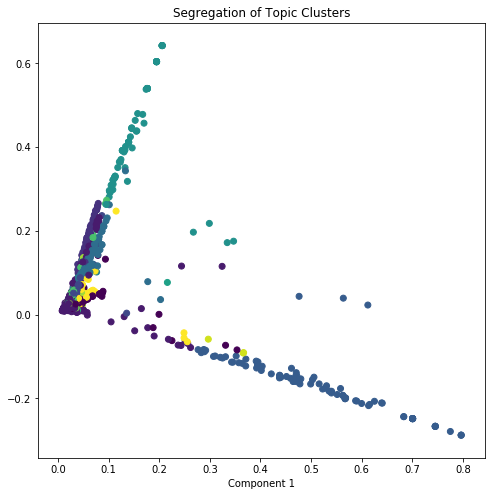

In [21]:
# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [22]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#Getting Similar documents
def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    return doc_ids, np.take(documents, doc_ids)

In [23]:
#Fetching the answers' document
def answer_abstract(myquery):
    import array as arr 
    arr = [0,0,0,0,0]
    mytext = [myquery]
    doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=5, verbose=True)
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(myquery)
    i=0
    for doc in docs:
        for tok in tokens:
            if tok in doc:
                arr[i]+=1
        i=i+1
    docindex = arr.index(max(arr))
    answerline = str(docs[docindex])
    return(answerline)

In [24]:
question = pd.read_csv("questions.csv", encoding='utf8')
ans_abs=[]
for index,row in question.iterrows():
    query = row['question']
    answerline = answer_abstract(query)
    ans_abs.append(answerline)
question['Predicted Abstract'] = ans_abs

In [25]:
question

,question,Actual Abstract,Predicted Abstract
0,Name an American actor who was the president o...,John Gavin (born Juan Vincent Apablasa Jr.; Ap...,John Gavin (born Juan Vincent Apablasa Jr.; Ap...
1,"What was Louise Bours, a Member of the Europea...","Louise Bours (born 23 December 1968), also kno...","Louise Bours (born 23 December 1968), also kno..."
2,"Name a British politician, who was a Member of...",Elizabeth Lynne (born 22 January 1948) is a Br...,"David Lloyd George, 1st Earl Lloyd-George of D..."
3,Name a British character actor who appeared in...,James Robertson Justice (born James Norval Har...,James Robertson Justice (born James Norval Har...
4,What was Muhammad Yusuf Khan professionally kn...,"Muhammad Yusuf Khan (born 11 December 1922), k...","John Augustus Kelly Jr. (September 16, 1927 – ..."
...,...,...,...
396,"Who is Harold Peter ""Herb"" Capozzi?","Harold Peter ""Herb"" Capozzi (April 24, 1925 – ...","Simeon Galvez Toribio (September 3, 1905 – Jun..."
397,"What was Charles Griffith Wynne, Liberal Tory...",Charles Griffith Wynne (14 August 1815 – 3 Mar...,Charles Griffith Wynne (14 August 1815 – 3 Mar...
398,Name an English Christian worship leader and w...,Stuart Townend (born 1963) is an English Chris...,Stuart Townend (born 1963) is an English Chris...
399,Who is Michael James Tomlinson-Mynors?,Michael James Tomlinson-Mynors (born 1 October...,"Simeon Galvez Toribio (September 3, 1905 – Jun..."


In [26]:
#Predicting the exact answer using spaCy Matcher & EntityRuler 
aka = ['known as', 'nicknamed', 'known mononymously as', 'known professionally as']
bday = ['born?']
death = ['die?']
name = ['Name']
who = ['Who']
answerlist=[]
for index,row in question.iterrows():
    query = row['question']
    querylist = query.split()
    answerline = row['Predicted Abstract']
    if row['Predicted Abstract'].split()[0] == row['Actual Abstract'].split()[0] and row['Predicted Abstract'].split()[1] == row['Actual Abstract'].split()[1]:
        for querywords in querylist:
            if querywords in bday:
                answerlist.append(birthdate(answerline))
            if querywords in death:
                answerlist.append(deathday(answerline))
            if querywords in who:
                answerlist.append(answerline)
            if querywords in name:
                answerlist.append(nameofperson(answerline))
        for phrase in aka:
            if phrase in query:
                answerlist.append(alsoknownas(answerline))
    else:
        answerlist.append("Answer not found!")
question['Answer'] = answerlist

In [32]:
question

,question,Actual Abstract,Predicted Abstract,Answer
0,Name an American actor who was the president o...,John Gavin (born Juan Vincent Apablasa Jr.; Ap...,John Gavin (born Juan Vincent Apablasa Jr.; Ap...,John Gavin
1,"What was Louise Bours, a Member of the Europea...","Louise Bours (born 23 December 1968), also kno...","Louise Bours (born 23 December 1968), also kno...",Louise van de Bours
2,"Name a British politician, who was a Member of...",Elizabeth Lynne (born 22 January 1948) is a Br...,"David Lloyd George, 1st Earl Lloyd-George of D...",Answer not found!
3,Name a British character actor who appeared in...,James Robertson Justice (born James Norval Har...,James Robertson Justice (born James Norval Har...,James Robertson Justice
4,What was Muhammad Yusuf Khan professionally kn...,"Muhammad Yusuf Khan (born 11 December 1922), k...","John Augustus Kelly Jr. (September 16, 1927 – ...",Answer not found!
...,...,...,...,...
396,"Who is Harold Peter ""Herb"" Capozzi?","Harold Peter ""Herb"" Capozzi (April 24, 1925 – ...","Simeon Galvez Toribio (September 3, 1905 – Jun...",Answer not found!
397,"What was Charles Griffith Wynne, Liberal Tory...",Charles Griffith Wynne (14 August 1815 – 3 Mar...,Charles Griffith Wynne (14 August 1815 – 3 Mar...,Charles WynneFinch
398,Name an English Christian worship leader and w...,Stuart Townend (born 1963) is an English Chris...,Stuart Townend (born 1963) is an English Chris...,Stuart Townend
399,Who is Michael James Tomlinson-Mynors?,Michael James Tomlinson-Mynors (born 1 October...,"Simeon Galvez Toribio (September 3, 1905 – Jun...",Answer not found!


In [28]:
question.to_csv('qa_lda.csv')

In [29]:
#Calculating Cosine Similarity between predicted and actual answers
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
cos_sim=[]
for index,row in question.iterrows():
    
    X = row['Predicted Abstract']
    Y = row['Actual Abstract']  
    # tokenization 
    X_list = word_tokenize(X)  
    Y_list = word_tokenize(Y) 
  
    # sw contains the list of stopwords 
    sw = stopwords.words('english')  
    l1 =[];l2 =[] 
  
    # remove stop words from string 
    X_set = {w for w in X_list if not w in sw}  
    Y_set = {w for w in Y_list if not w in sw} 
  
    # form a set containing keywords of both strings  
    rvector = X_set.union(Y_set)  
    for w in rvector: 
        if w in X_set: l1.append(1) # create a vector 
        else: l1.append(0) 
        if w in Y_set: l2.append(1) 
        else: l2.append(0) 
    c = 0
  
    # cosine formula  
    for i in range(len(rvector)): 
        c+= l1[i]*l2[i] 
    cosine = c / float((sum(l1)*sum(l2))**0.5) 
    cos_sim.append(cosine)

In [30]:
#Accuracy
print(sum(cos_sim)/len(cos_sim))

0.6195487050649204


In [38]:
#Sample question and answer
print('query: \n'+question.iloc[2]['question']+'\n')
print('answer: \n'+question.iloc[2]['Answer']+'\n')
print('paragraph: \n'+question.iloc[2]['Predicted Abstract']+'\n')

query: 
Name a British politician, who was a Member of the European Parliament (MEP) for the West Midlands?

answer: 
Answer not found!

paragraph: 
David Lloyd George, 1st Earl Lloyd-George of Dwyfor,   (17 January 1863 – 26 March 1945) was a British statesman who served as Prime Minister of the United Kingdom from 1916 to 1922.

